****
# Multiprocessing MonteCarlo Simulation for Option Pricing
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: November 2013<br>Last revision: September 2015</i></p>
## About this notebook: 
Notebook prepared by **Jesus Perez Colino** Version 0.1, First Released: 01/12/2014, Alpha.  

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: This notebook is just the simplest implementation of a Multiprocessing Monte-Carlo Simulation engine for the **European option** pricing.


- **Python & packages versions** to reproduce the results of this notebook: 

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import IPython
from scipy.stats import norm
from abc import ABCMeta, abstractmethod
from sys import version 
import multiprocessing
from numpy import ceil, mean
import time
import os

print ' Reproducibility conditions for this notebook '.center(90,'-')
print 'Python version:     ' + version
print 'Numpy version:      ' + np.__version__
print 'IPython version:    ' + IPython.__version__
print 'Multiprocessing:    ' + multiprocessing.__version__
print '-'*90

---------------------- Reproducibility conditions for this notebook ----------------------
Python version:     2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Sep 15 2015, 14:29:08) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Numpy version:      1.9.2
IPython version:    4.0.0
Multiprocessing:    0.70a1
------------------------------------------------------------------------------------------


## Base and Derived Classes for the Option Pricing

In [2]:
class EuropeanOption(object):
    """ Abstract Class for European options. Partially implemented.
    S0 : float : initial stock/index level
    strike : float : strike price
    T : float : time to maturity (in year fractions)
    r : float : constant risk-free short rate
    div :    float : dividend yield
    sigma :  float : volatility factor in diffusion term
    model: str: name of the model for the pricing"""

    __metaclass__ = ABCMeta

    def __init__(self, option_type, S0, strike, T, r, div, sigma, model):
        try:
            self.option_type = option_type
            assert isinstance(option_type, str)
            self.S0 = float(S0)
            self.strike = float(strike)
            self.T = float(T)
            self.r = float(r)
            self.div = float(div)
            self.sigma = float(sigma)
            self.model = str(model)
        except ValueError:
            print('Error passing Options parameters')

        models = ['BlackScholes', 'MonteCarlo', 
                  'BinomialTree', 'TrinomialTree',
                  'FFT', 'PDE']
        
        if model not in models:
            raise Exception('Error: Model unknown')
            
        option_types = ['call', 'put']
        
        if option_type not in option_types:
            raise ValueError("Error: Option type not valid. Enter 'call' or 'put'")
        if S0 < 0 or strike < 0 or T <= 0 or r < 0 or div < 0 or sigma < 0:
            raise ValueError('Error: Negative inputs not allowed')
            
        self.discount = np.exp(-self.r * self.T)

    def getmodel(self):
        return self.model

    def __str__(self):
        return "This European Option is priced using {0}".format(self.getmodel())

    @abstractmethod
    def value(self):
        pass
    
    @abstractmethod
    def delta(self):
        pass
        

In [3]:
class BlackScholes(EuropeanOption):

    def __init__(self, option_type, S0, strike, T, r, div, sigma):
        EuropeanOption.__init__(self,option_type, S0, strike, 
                                T, r, div, sigma, 'BlackScholes')
        
        d1 = ((np.log(self.S0 / self.strike) + 
              (self.r - self.div + 0.5 * (self.sigma ** 2)) * self.T) / 
              float( self.sigma * np.sqrt(self.T)))
        d2 = float(d1 - self.sigma * np.sqrt(self.T))
        self.Nd1 = norm.cdf(d1, 0, 1)
        self.Nnd1 = norm.cdf(-d1, 0, 1)
        self.Nd2 = norm.cdf(d2, 0, 1)
        self.Nnd2 = norm.cdf(-d2, 0, 1)
        self.pNd1 = norm.pdf(d1, 0, 1)
        
    @property
    def value(self):
        if self.option_type == 'call':
            value = (self.S0 * np.exp(-self.div * self.T) * self.Nd1 -
                     self.strike * np.exp(-self.r * self.T) * self.Nd2)
        else:
            value = (self.strike * np.exp(-self.r * self.T) * self.Nnd2 -
                     self.S0 * np.exp(-self.div * self.T) * self.Nnd1)
        return value
    
    @property
    def delta(self):
        if self.option_type == 'call':
            delta = np.exp(- self.div * self.T) * self.Nd1
        else:
            delta = np.exp(- self.div * self.T) * (self.Nd1 - 1)
        return delta

In [4]:
class MonteCarlo(EuropeanOption):

    def __init__(self, simulations, option_type, S0, strike, T, r, div, sigma, 
                 antithetic = True, 
                 moment_matching = True, 
                 fixed_seed = True):
        EuropeanOption.__init__(self, option_type, S0, strike, T, r, div, sigma, "MonteCarlo")
        try:
            self.antithetic = bool(antithetic)
            self.moment_matching = bool(moment_matching)
            self.fixed_seed = bool(fixed_seed)
            if self.simulations > 0 :
                self.simulations = int(simulations)
            else:
                raise ValueError("Simulation's number has to be positive integer")                    
        except:
            raise ValueError("Problem assigning types in MC arguments")
    
    def simulation_terminal(self, seed = 1234567890):
        if self.fixed_seed:
            assert isinstance(seed, int)
            np.random.seed(seed)
        if self.antithetic: 
            brownian = np.random.standard_normal(size = int(np.ceil(self.simulations/2.)))
            brownian = np.concatenate((brownian, -brownian))
        else:
            brownian = np.random.standard_normal(size = self.simulations)
        if self.moment_matching: 
            brownian = brownian - np.mean(brownian)
            brownian = brownian / np.std(brownian)
            
        price_terminal = self.S0 * np.exp((self.r - self.div - 0.5 * self.sigma ** 2) *
                                          self.T +
                                          self.sigma * np.sqrt(self.T) * brownian)
        return price_terminal

    def generate_payoffs(self):
        price_terminal = self.simulation_terminal()
        if self.option_type == 'call':
            payoff = np.maximum((price_terminal - self.strike), 0)
        else:
            payoff = np.maximum((self.strike - price_terminal), 0)
        return payoff

    @property
    def value(self):
        payoff = self.generate_payoffs()
        return self.discount * np.sum(payoff) / float(len(payoff))
    
    @property
    def delta(self):
        value_terminal = np.array(self.simulation_terminal() / float(self.S0))
        payoff = self.generate_payoffs()
        delta = np.zeros(len(payoff))
        delta[np.nonzero(payoff)] = value_terminal[np.nonzero(payoff)]
        return self.discount * np.sum(delta) / float(len(payoff))

## Multiprocessing MonteCarlo: Functions, Pool, Mapping and Join

In [5]:
def value_in_pool(simulations):
    if isinstance(simulations, int):
        simulations = [simulations] 
    arguments = ['call', 100., 100., .5, 0.01, 0., .35]
    reduce(lambda x,y : x.extend(y), [simulations, arguments])
    return MonteCarlo(*simulations).value

In [6]:
def delta_in_pool(simulations):
    if isinstance(simulations, int):
        simulations = [simulations] 
    arguments = ['call', 100., 100., .5, 0.01, 0., .35]
    reduce(lambda x,y : x.extend(y), [simulations, arguments])
    return MonteCarlo(*simulations).delta

In [7]:
call = BlackScholes('call', 100., 100., .5, 0.01, 0., .35)
print '-' * 85
print 'BS Price:', call.value, 'BS Delta:', call.delta
print '-' * 85
scenarios = {'1': [1e4, 1e7], 
             '2': [1e4, 1e7], 
             '3': [1e4, 1e7],
             '4': [1e4, 1e7],
             '5': [1e4, 1e7],
             '6': [1e4, 1e7]}
results = {}
for num_processes in scenarios:
    for N in scenarios[num_processes]:
        start = time.time()
        chunks = [int(ceil(N / int(num_processes)))] * int(num_processes)
        chunks[-1] = int(chunks[-1] - sum(chunks) + N)
        p = multiprocessing.Pool(int(num_processes))
        option_value = p.map(value_in_pool, chunks)
        p.close()
        p.join()
        q = multiprocessing.Pool(int(num_processes))
        option_delta = q.map(delta_in_pool, chunks)
        q.close()
        q.join()
        end = time.time()
        print 'Number of processors:', num_processes + ',',
        print 'Number of simulations:', str(int(N))
        print 'Monte Carlo Option Price:', str(mean(option_value)) + ',',
        print 'Monte Carlo Option Delta:', str(mean(option_delta))
        print 'Time, in sec:', str(end - start)
        print '-' * 85
        if N == 1e7: results[num_processes] = (end - start) 


-------------------------------------------------------------------------------------
BS Price: 10.074989532 BS Delta: 0.557228735645
-------------------------------------------------------------------------------------
Number of processors: 1, Number of simulations: 10000
Monte Carlo Option Price: 10.0555595453, Monte Carlo Option Delta: 0.558460338378
Time, in sec: 0.387418031693
-------------------------------------------------------------------------------------
Number of processors: 1, Number of simulations: 10000000
Monte Carlo Option Price: 10.0755354762, Monte Carlo Option Delta: 0.5572977266
Time, in sec: 2.33576083183
-------------------------------------------------------------------------------------
Number of processors: 3, Number of simulations: 10000
Monte Carlo Option Price: 10.0701067309, Monte Carlo Option Delta: 0.558207802041
Time, in sec: 0.246520042419
-------------------------------------------------------------------------------------
Number of processors: 3, Nu

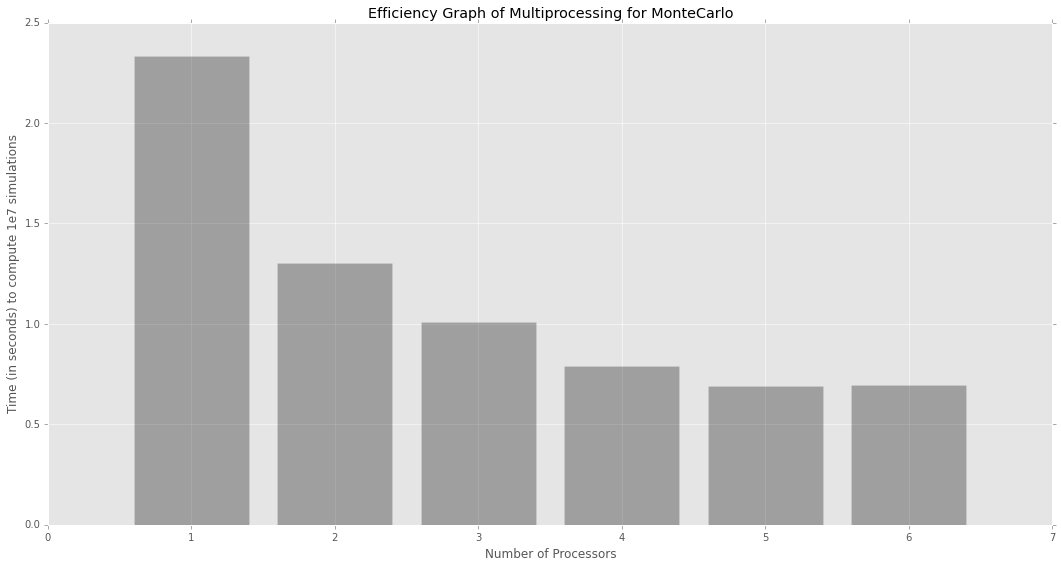

In [21]:
plt.figure(num=None, figsize=(18, 9))
plt.style.use('ggplot')
processors = [float(i) for i in results.keys()]
times = [float(i) for i in results.values()]
plt.bar(processors, times, align='center', alpha=0.3, color = 'black')
plt.title('Efficiency Graph of Multiprocessing for MonteCarlo')
plt.xlabel('Number of Processors')
plt.ylabel('Time (in seconds) to compute 1e7 simulations');